In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn import metrics
from matplotlib.ticker import PercentFormatter

In [3]:
raw_dat_dir = '/home/grace/Documents/python/genetox/data/raw/'
processed_dat_dir = '/home/grace/Documents/python/genetox/data/processed/'
interim_dat_dir = '/home/grace/Documents/python/genetox/data/interim/'
figures_dir = '/home/grace/Documents/python/genetox/reports/figures/'

In [4]:
from sklearn.metrics import confusion_matrix
from itertools import combinations
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

In [5]:
import sys
sys.path.append('/home/grace/Documents/python/genetox/models/')

from mlfunctions import *

In [6]:
df_marini = pd.read_csv(processed_dat_dir+'DeMarini_calls_120221.csv')

In [7]:
df_marini.set_index('dtxsid', inplace = True)

In [8]:
TEST_preds = pd.read_csv(processed_dat_dir+'TEST_consensus_Ames_predictions_100221.csv')

In [9]:
df_test = TEST_preds.copy()

In [10]:
df_test = df_test[['DTXSID_of_genetox_chemical','TEST_prediction']]

In [11]:
df_test.columns = ['DTXSID', 'TEST']

In [12]:
df_test.index = df_test['DTXSID']

In [13]:
df_test.rename(columns = {'TEST': 'T1'}, inplace = True)

In [14]:
VEGA_pred = pd.read_csv(processed_dat_dir+'VEGA_pred_numeric_100221.csv')

In [15]:
df_vega = VEGA_pred.copy()

In [16]:
df_vega.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [17]:
df_vega.rename(columns = {'Mutagenicity (Ames test) CONSENSUS model - prediction' : 'T2',\
       'Mutagenicity (Ames test) model (CAESAR) - prediction' : 'T3',\
       'Mutagenicity (Ames test) model (SarPy/IRFMN) - prediction': 'T4',\
       'Mutagenicity (Ames test) model (ISS) - prediction': 'T5',\
       'Mutagenicity (Ames test) model (KNN/Read-Across) - prediction': 'T6',\
       'Chromosomal aberration model (CORAL) - prediction': 'T7',\
       'In vitro Micronucleus activity (IRFMN/VERMEER) - prediction': 'T8',\
       'In vivo Micronucleus activity (IRFMN) - prediction': 'T9'}, inplace = True)

In [18]:
df_vega.index = df_vega['dtxsid']

In [19]:
OECD = pd.read_csv(processed_dat_dir+'OECD_TB_numeric_100221.csv')

In [20]:
OECD.drop(['Unnamed: 0'], axis=1, inplace = True)

In [21]:
OECD = OECD[['DTXSID', 'DNA_Ames_OASIS', 'DNA_binding_OASIS',
       'DNA_binding_OECD', 'Protein_binding_CA_OASIS', 'Ames_ISS',
       'MNT_ISS']]

In [22]:
df_oecd = OECD.copy()

In [23]:
df_oecd.index = df_oecd['DTXSID']

In [24]:
df_oecd.rename(columns = {'DNA_Ames_OASIS': 'A1',\
                          'DNA_binding_OASIS': 'A2',\
                          'DNA_binding_OECD': 'A3',\
       'Protein_binding_CA_OASIS': 'A4', \
                          'Ames_ISS': 'A5',\
                          'MNT_ISS': 'A6'}, inplace = True)

In [25]:
x = pd.concat([df_test['T1'], df_vega, df_oecd], axis =1, sort = True)

In [26]:
x.drop(['dtxsid', 'DTXSID'], axis = 1, inplace = True)

In [27]:
corr_pearson = x.corr(method = 'pearson')

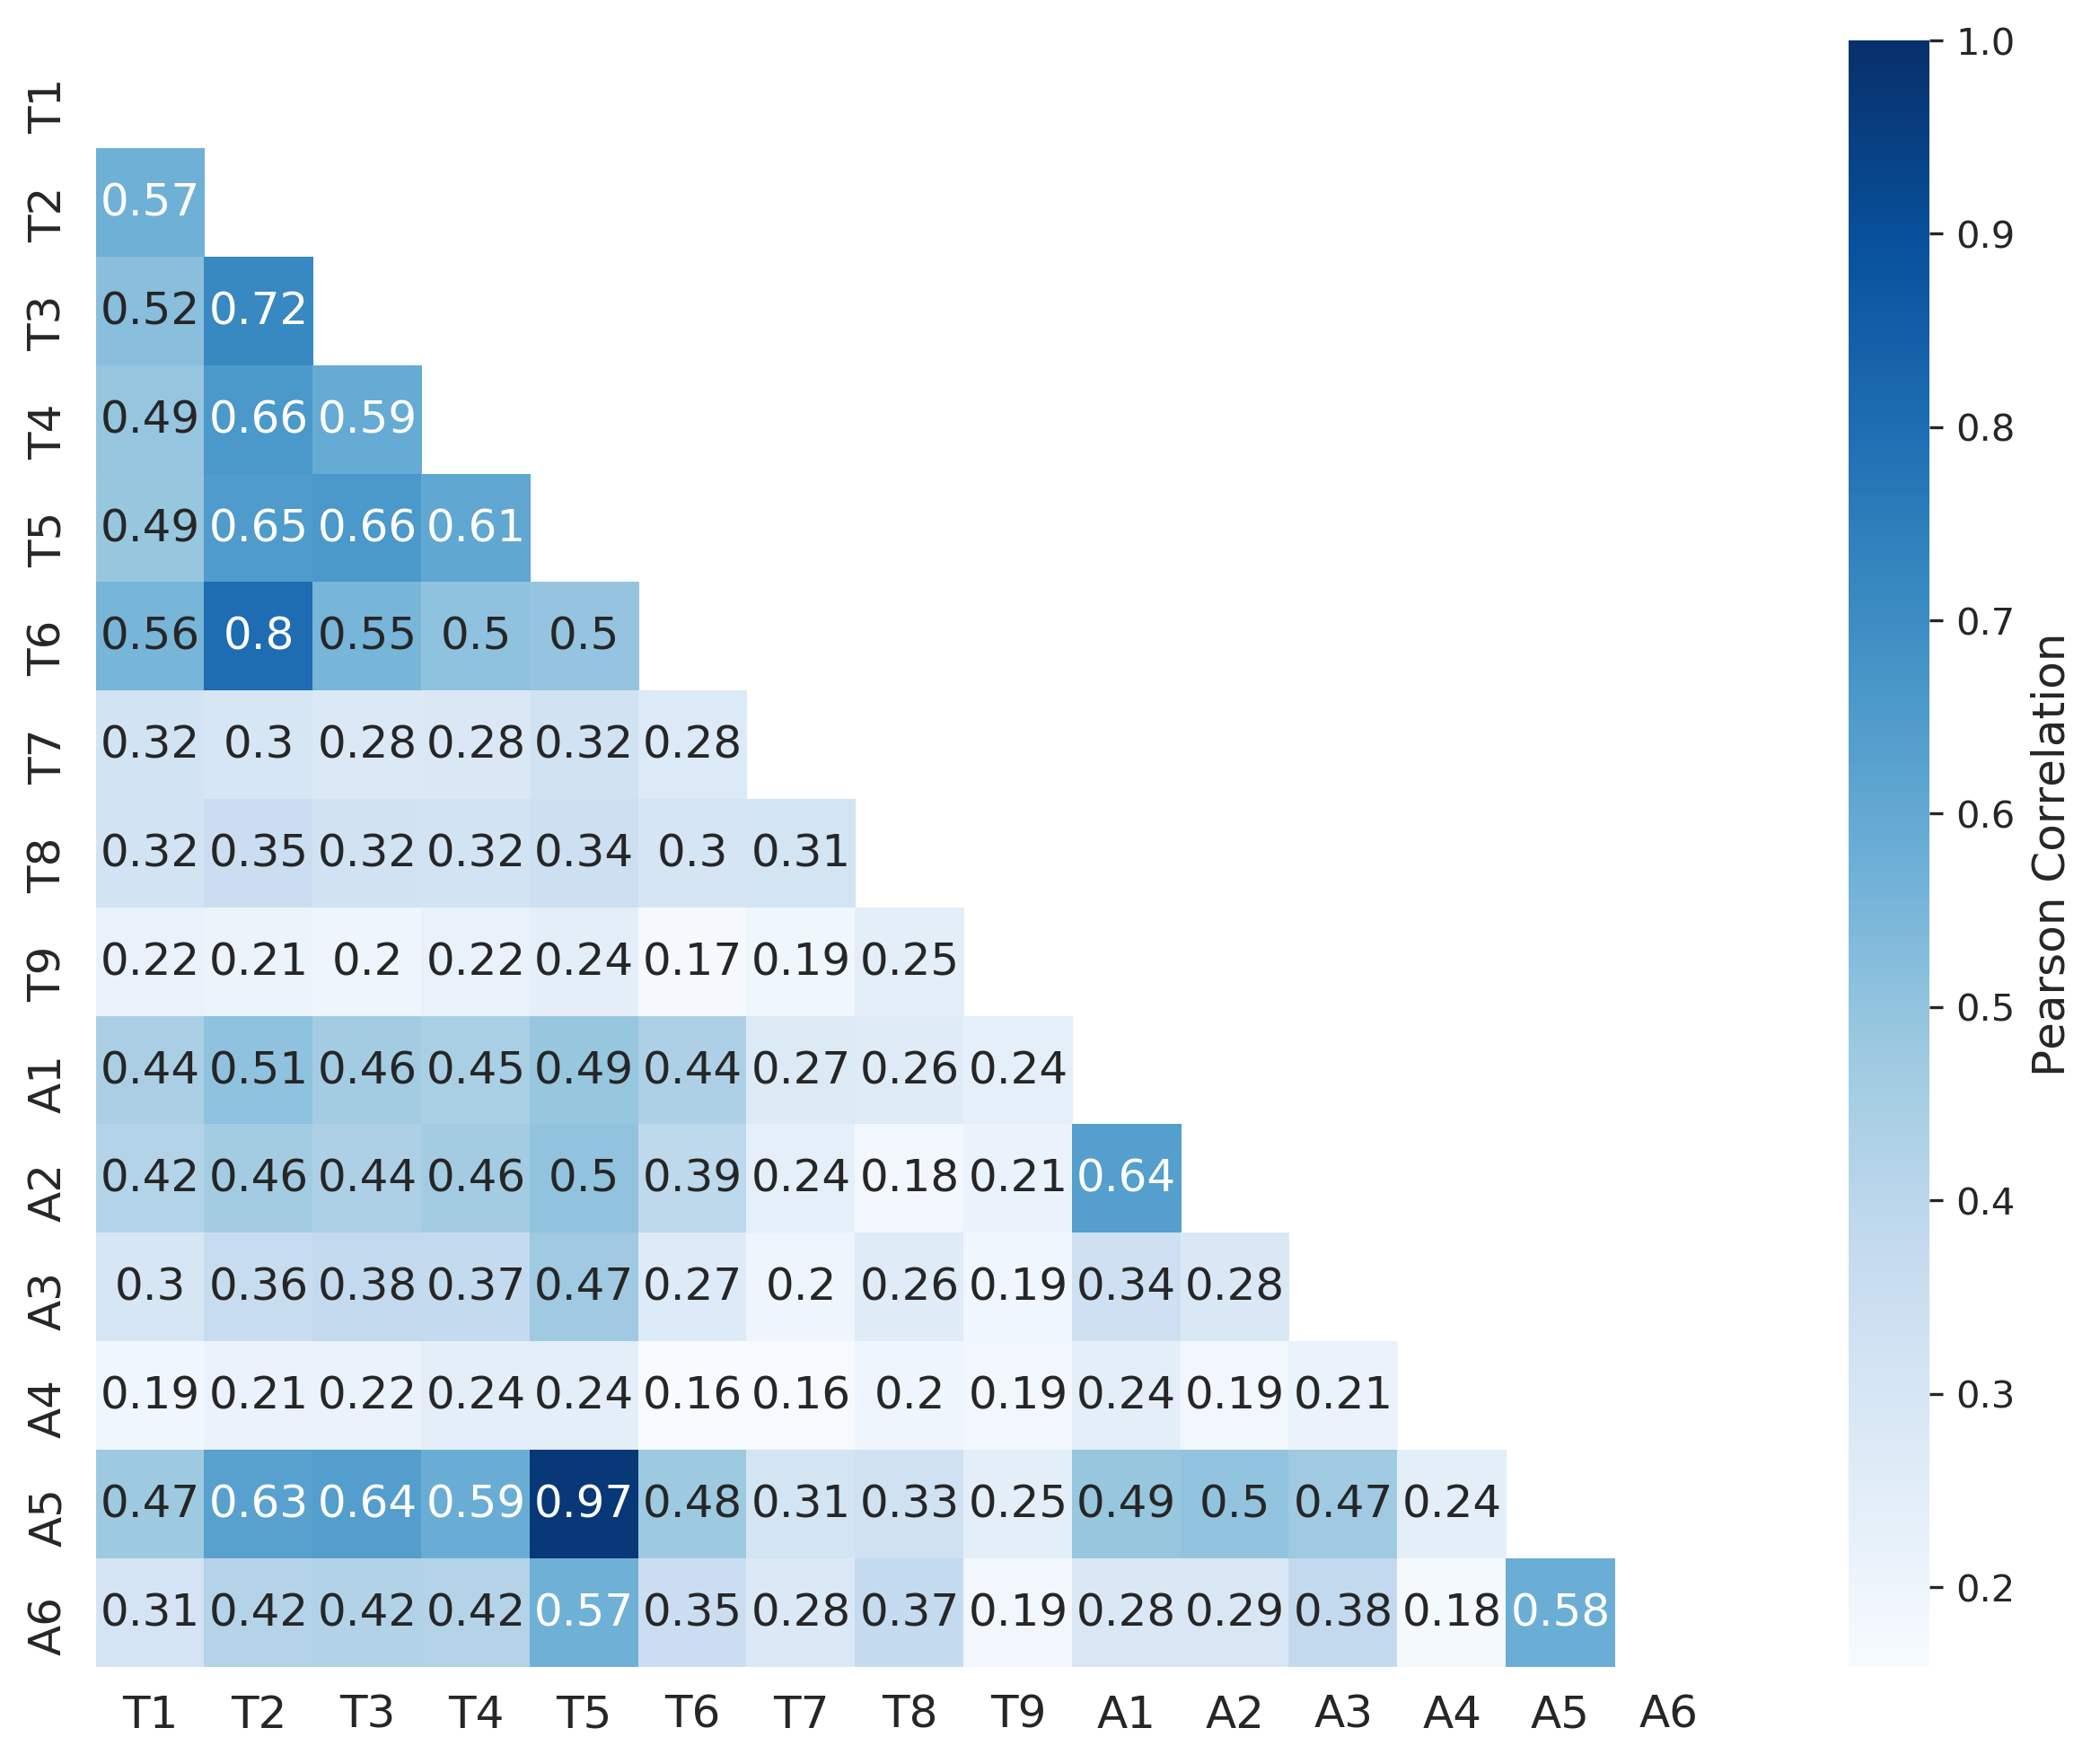

In [29]:
# Evaluate and plot correlation
corr_pearson = x.corr(method='pearson')
plt.figure(figsize=(12, 8), dpi = 300)
mask = np.zeros_like(corr_pearson)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr_pearson, mask=mask, vmax=1, square=True, cmap="Blues", 
                     annot=True, cbar_kws={'label': 'Pearson Correlation'}, annot_kws={"size": 12})
ax.figure.axes[-1].yaxis.label.set_size(12)    
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(figures_dir+'ToolsCorr_160221.png', bbox_inches='tight')


In [30]:
x = correlation(x, 0.79)

A1, A4 and T9 had v low sensitivities.

In [32]:
x.drop(['A1', 'A4', 'T9'], axis = 1, inplace = True)

In [33]:
x.head()

,T1,T2,T3,T4,T5,T7,T8,A2,A3,A6
DTXSID00148597,1.0,1,1.0,1,1,0,NaN,1.0,1.0,1.0
DTXSID00157169,1.0,1,1.0,1,1,1,1.0,1.0,1.0,1.0
DTXSID00158116,1.0,1,1.0,1,1,0,1.0,1.0,1.0,1.0
DTXSID00159204,0.0,1,1.0,1,1,0,NaN,0.0,1.0,1.0
DTXSID00160734,0.0,0,0.0,0,0,1,1.0,0.0,0.0,1.0


In [37]:

ntools = len(x.columns)
x_combns = pd.DataFrame(index=x.index)
for n in range(2,ntools+1):
    cc = np.array(list(combinations(x.columns, n)))
    print(len(cc))
    for c in cc:
        # combination 1
        x_combns['comb1_%d-%s'%(n,''.join(c))] = x[c].sum(axis=1)
        # combination 2
        s = 0
        for p, tool in enumerate(c):
            s=s+2**p*x[tool]
        x_combns['comb2_%d-%s'%(n,''.join(c))] = s

combns = x_combns.columns.tolist()

45
120
210
252
210
120
45
10
1


In [50]:
x_combns['demarini'] = df_marini['DeMarini_outcome']
# Divide into test and training datasets
kf = KFold(n_splits=5) # Define the split - into 5 folds 
kf.get_n_splits(x_combns) # returns the number of splitting iterations in the cross-validator

# Make the predictions
predictions_x_combns = pd.DataFrame()
for train_index, test_index in kf.split(x_combns):
    train_set, test_set = x_combns.iloc[train_index], x_combns.iloc[test_index]
    print(train_set['demarini'].value_counts(), test_set['demarini'].value_counts())

0.0    3503
1.0    1850
Name: demarini, dtype: int64 0.0    864
1.0    460
Name: demarini, dtype: int64
0.0    3506
1.0    1830
Name: demarini, dtype: int64 0.0    861
1.0    480
Name: demarini, dtype: int64
0.0    3507
1.0    1842
Name: demarini, dtype: int64 0.0    860
1.0    468
Name: demarini, dtype: int64
0.0    3475
1.0    1862
Name: demarini, dtype: int64 0.0    892
1.0    448
Name: demarini, dtype: int64
0.0    3477
1.0    1856
Name: demarini, dtype: int64 0.0    890
1.0    454
Name: demarini, dtype: int64


In [52]:
3503/1850
861/480

1.79375

In [44]:
x_combns['demarini'].value_counts()

0.0    4367
1.0    2310
Name: demarini, dtype: int64

In [37]:
x_combns['demarini'] = df_marini['DeMarini_outcome']
# Divide into test and training datasets
kf = KFold(n_splits=5) # Define the split - into 5 folds 
kf.get_n_splits(x_combns) # returns the number of splitting iterations in the cross-validator

# Make the predictions
predictions_x_combns = pd.DataFrame()
for train_index, test_index in kf.split(x_combns):
    train_set, test_set = x_combns.iloc[train_index], x_combns.iloc[test_index]
    #Calculate posteriors from training set
    post_prob = {}
    for combn in combns:
        for comb in train_set[combn].dropna().unique():
            try:
                n_comb = len(train_set[train_set[combn]==comb])
                n_1_comb = len(train_set[(train_set[combn]==comb) & (train_set['demarini']==1)])
                post_prob[comb] = round(n_1_comb/n_comb,2)
            except:
                post_prob[comb] = np.nan
                
        # Calculate new predictions for test set
        for idx in test_set.index:
            comb = test_set.loc[idx, combn]
            for prob_cutoff in [0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]:
                try:
                    if post_prob[comb] >= prob_cutoff:
                        predictions_x_combns.loc[idx, '%s_PredCutOff%0.2f' %(combn,prob_cutoff)] = 1
                    else:
                        predictions_x_combns.loc[idx, '%s_PredCutOff%0.2f' %(combn,prob_cutoff)] = 0
                except:
                    if comb==0:
                        predictions_x_combns.loc[idx, '%s_PredCutOff%0.2f' %(combn,prob_cutoff)] = 0
                    elif comb==sum([2**x for x in range(1,ntools+1)]):
                        predictions_x_combns.loc[idx, '%s_PredCutOff%0.2f' %(combn,prob_cutoff)] = 1   
                    else:
                        predictions_x_combns.loc[idx, '%s_PredCutOff%0.2f' %(combn,prob_cutoff)] = np.nan #'Cannot predict'    



In [40]:
predictions_x_combns.to_csv(processed_dat_dir+'predictions_x_combns.csv')

In [43]:
predictions_x_combns.shape

(7511, 18234)

In [47]:
[e for e in x_combns.columns.tolist() if 'demarin' in e]

['demarini']

In [49]:
metrics_x_combns = pd.DataFrame(columns = ['EnsembleCombination', 'Truth', 'Prediction_CutOff', 'nTools', 'Total', 'Accuracy', 'Sensitivity', 'Specificity', 'Balanced Accuracy', 'Kappa']) 
for combn in combns:
    # vary over cut-offs used in prediction
    for prob_cutoff in [0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]:
        xy = pd.concat([predictions_x_combns['%s_PredCutOff%0.2f' %(combn,prob_cutoff)], x_combns['demarini']], axis = 1).dropna()
        cnf_matrix = confusion_matrix(xy['%s_PredCutOff%0.2f' %(combn,prob_cutoff)],xy['demarini'])
        n = int(combn.split('_')[1][0])
        try:
            total, acc, sens, spec, ba, kappa, ppv, npv = calcMetrics(cnf_matrix)
        except ZeroDivisionError as error:
            print(error)
        else:
            metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'EnsembleCombination'] = combn
            metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'Truth'] = 'Williamns et al. 2019 Calls'
            metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'Prediction_CutOff'] = prob_cutoff
            metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'nTools'] = 'n=%d' %n
            metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'Total'] = total
            metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'Accuracy'] = acc
            metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'Sensitivity'] = sens
            metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'Specificity'] = spec
            metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'Balanced Accuracy'] = ba
            metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'Kappa'] = kappa
            metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'PPV'] = ppv
            metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'NPV'] = npv
metrics_x_combns.to_csv(processed_dat_dir+'metrics_combns_170221.csv', index_label = 'Combination')



float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float divis

In [124]:
metrics_x_combns = pd.read_csv(processed_dat_dir+'metrics_combns_170221.csv')

In [125]:
metrics_x_combns.head()

,Combination,EnsembleCombination,Truth,Prediction_CutOff,nTools,Total,Accuracy,Sensitivity,Specificity,Balanced Accuracy,Kappa,PPV,NPV
0,comb1_2-T1T2_PredCutOff0.20|DeMarini,comb1_2-T1T2,Williamns et al. 2019 Calls,0.20,n=2,6677.0,73.25,60.36,81.10,70.73,0.42,66.06,77.06
1,comb1_2-T1T2_PredCutOff0.25|DeMarini,comb1_2-T1T2,Williamns et al. 2019 Calls,0.25,n=2,6677.0,73.25,60.36,81.10,70.73,0.42,66.06,77.06
2,comb1_2-T1T2_PredCutOff0.30|DeMarini,comb1_2-T1T2,Williamns et al. 2019 Calls,0.30,n=2,6677.0,73.25,60.36,81.10,70.73,0.42,66.06,77.06
3,comb1_2-T1T2_PredCutOff0.35|DeMarini,comb1_2-T1T2,Williamns et al. 2019 Calls,0.35,n=2,6677.0,73.25,60.36,81.10,70.73,0.42,66.06,77.06
4,comb1_2-T1T2_PredCutOff0.40|DeMarini,comb1_2-T1T2,Williamns et al. 2019 Calls,0.40,n=2,6677.0,76.44,79.79,75.68,77.74,0.42,42.73,94.28


In [126]:
metrics_x_combns.set_index('Combination', inplace = True)

In [127]:


metrics_x_combns.shape

(16994, 12)

In [128]:
metrics_x_combns.describe()

,Prediction_CutOff,Total,Accuracy,Sensitivity,Specificity,Balanced Accuracy,Kappa,PPV,NPV
count,16994.000000,16994.000000,16994.000000,16994.000000,16994.000000,16994.000000,16994.000000,16994.000000,16994.000000
mean,0.363767,5995.958632,72.728609,65.983247,78.733944,72.358669,0.389890,56.741426,81.080179
std,0.121675,840.181748,6.943841,11.148900,3.600869,4.770568,0.087288,14.624911,16.483288
min,0.150000,4426.000000,34.320000,30.000000,0.000000,17.260000,0.000000,0.140000,0.000000
25%,0.250000,4846.000000,72.170000,59.422500,76.570000,69.950000,0.360000,46.540000,77.020000
50%,0.350000,6445.000000,74.750000,67.420000,79.030000,73.190000,0.410000,56.710000,85.950000
75%,0.450000,6677.000000,76.430000,74.677500,81.020000,75.750000,0.450000,65.890000,91.890000
max,0.550000,6677.000000,80.370000,88.170000,94.120000,81.220000,0.530000,99.950000,99.830000


In [107]:
metrics_df = metrics_x_combns.copy()

In [54]:
predictions_x_combns.shape


(7511, 18234)

In [105]:
#for col in metrics_x_combns2.columns.tolist()[4:]:
#    metrics_x_combns2[col] = metrics_x_combns2[col].astype(float)
    
    
#metrics_x_combns2.describe()    

In [131]:
metrics_df.shape

(16994, 12)

In [182]:
metrics_df.sort_values(['Balanced Accuracy', 'Sensitivity'], ascending = [False, False])

,EnsembleCombination,Truth,Prediction_CutOff,nTools,Total,Accuracy,Sensitivity,Specificity,Balanced Accuracy,Kappa,PPV,NPV
Combination,,,,,,,,,,,,
comb2_4-T1T5T8A3_PredCutOff0.55|DeMarini,comb2_4-T1T5T8A3,Williamns et al. 2019 Calls,0.55,n=4,4542.0,76.86,87.24,75.20,81.22,0.39,36.03,97.35
comb2_6-T1T2T7T8A3A6_PredCutOff0.55|DeMarini,comb2_6-T1T2T7T8A3A6,Williamns et al. 2019 Calls,0.55,n=6,4542.0,77.96,85.85,76.47,81.16,0.43,40.78,96.63
comb2_5-T1T2T8A3A6_PredCutOff0.55|DeMarini,comb2_5-T1T2T8A3A6,Williamns et al. 2019 Calls,0.55,n=5,4542.0,77.63,86.17,76.09,81.13,0.42,39.39,96.83
comb2_5-T1T5T8A3A6_PredCutOff0.55|DeMarini,comb2_5-T1T5T8A3A6,Williamns et al. 2019 Calls,0.55,n=5,4542.0,76.95,86.74,75.34,81.04,0.39,36.63,97.19
comb2_5-T1T3T5T8A3_PredCutOff0.55|DeMarini,comb2_5-T1T3T5T8A3,Williamns et al. 2019 Calls,0.55,n=5,4542.0,76.66,86.94,75.04,80.99,0.38,35.51,97.32
...,...,...,...,...,...,...,...,...,...,...,...,...
comb2_5-T1T3T7A2A6_PredCutOff0.15|DeMarini,comb2_5-T1T3T7A2A6,Williamns et al. 2019 Calls,0.15,n=5,5960.0,34.51,34.51,40.00,37.25,-0.00,99.85,0.05
comb2_4-T5A2A3A6_PredCutOff0.15|DeMarini,comb2_4-T5A2A3A6,Williamns et al. 2019 Calls,0.15,n=4,6179.0,34.33,34.33,33.33,33.83,-0.00,99.91,0.02
comb2_5-T3T4T5T7A3_PredCutOff0.15|DeMarini,comb2_5-T3T4T5T7A3,Williamns et al. 2019 Calls,0.15,n=5,6178.0,34.32,34.32,25.00,29.66,-0.00,99.86,0.02


In [183]:
metrics_df[metrics_df['EnsembleCombination'] == 'comb2_4-T1T5T8A3']

,EnsembleCombination,Truth,Prediction_CutOff,nTools,Total,Accuracy,Sensitivity,Specificity,Balanced Accuracy,Kappa,PPV,NPV
Combination,,,,,,,,,,,,
comb2_4-T1T5T8A3_PredCutOff0.15|DeMarini,comb2_4-T1T5T8A3,Williamns et al. 2019 Calls,0.15,n=4,4542.0,57.86,43.46,86.66,65.06,0.24,86.69,43.39
comb2_4-T1T5T8A3_PredCutOff0.20|DeMarini,comb2_4-T1T5T8A3,Williamns et al. 2019 Calls,0.20,n=4,4542.0,70.04,53.83,83.33,68.58,0.38,72.60,68.75
comb2_4-T1T5T8A3_PredCutOff0.25|DeMarini,comb2_4-T1T5T8A3,Williamns et al. 2019 Calls,0.25,n=4,4542.0,75.85,63.16,82.74,72.95,0.46,66.53,80.52
comb2_4-T1T5T8A3_PredCutOff0.30|DeMarini,comb2_4-T1T5T8A3,Williamns et al. 2019 Calls,0.30,n=4,4542.0,76.46,65.18,81.91,73.55,0.47,63.50,82.97
comb2_4-T1T5T8A3_PredCutOff0.35|DeMarini,comb2_4-T1T5T8A3,Williamns et al. 2019 Calls,0.35,n=4,4542.0,76.64,66.59,81.01,73.80,0.46,60.41,84.79
comb2_4-T1T5T8A3_PredCutOff0.40|DeMarini,comb2_4-T1T5T8A3,Williamns et al. 2019 Calls,0.40,n=4,4542.0,76.60,67.25,80.42,73.84,0.46,58.43,85.71
comb2_4-T1T5T8A3_PredCutOff0.45|DeMarini,comb2_4-T1T5T8A3,Williamns et al. 2019 Calls,0.45,n=4,4542.0,77.21,78.31,76.96,77.63,0.43,44.01,93.88
comb2_4-T1T5T8A3_PredCutOff0.50|DeMarini,comb2_4-T1T5T8A3,Williamns et al. 2019 Calls,0.50,n=4,4542.0,77.01,81.02,76.20,78.61,0.41,40.78,95.21
comb2_4-T1T5T8A3_PredCutOff0.55|DeMarini,comb2_4-T1T5T8A3,Williamns et al. 2019 Calls,0.55,n=4,4542.0,76.86,87.24,75.20,81.22,0.39,36.03,97.35


In [129]:

metrics_toplot = pd.DataFrame(columns=metrics_x_combns.columns)
for combn in combns:
    metrics_toplotsubset1 = metrics_x_combns[metrics_x_combns['EnsembleCombination']==combn]
    metrics_toplotsubset2 = metrics_toplotsubset1[metrics_toplotsubset1['Balanced Accuracy']==metrics_toplotsubset1['Balanced Accuracy'].max()]
    metrics_toplotsubset3 = metrics_toplotsubset2[metrics_toplotsubset2['Prediction_CutOff']==metrics_toplotsubset2['Prediction_CutOff'].max()]
    metrics_toplot=metrics_toplot.append(metrics_toplotsubset3)


In [130]:
metrics_toplot.shape

(2026, 12)

In [64]:
#metrics_toplot2 = metrics_toplot.copy()

In [65]:
#for col in metrics_toplot2.columns.tolist()[4:]:
#    metrics_toplot2[col] = metrics_toplot2[col].astype(float)

In [132]:
metrics_toplot.describe()

,Prediction_CutOff,Total,Accuracy,Sensitivity,Specificity,Balanced Accuracy,Kappa,PPV,NPV
count,2026.000000,2026.000000,2026.000000,2026.000000,2026.00000,2026.000000,2026.000000,2026.000000,2026.000000
mean,0.541461,6036.307502,75.324289,78.536905,74.92190,76.729571,0.376940,39.177354,94.188470
std,0.023489,827.589192,2.229872,4.802320,2.50314,2.461360,0.068141,8.410920,2.727268
min,0.350000,4426.000000,65.090000,49.530000,68.84000,61.190000,0.180000,15.760000,64.650000
25%,0.550000,5059.000000,73.900000,76.522500,73.10000,75.462500,0.330000,33.862500,93.470000
50%,0.550000,6677.000000,75.510000,79.660000,75.01500,77.255000,0.390000,40.175000,94.640000
75%,0.550000,6677.000000,77.077500,81.607500,76.76000,78.497500,0.430000,45.015000,95.810000
max,0.550000,6677.000000,80.320000,88.170000,82.12000,81.220000,0.520000,69.690000,98.490000


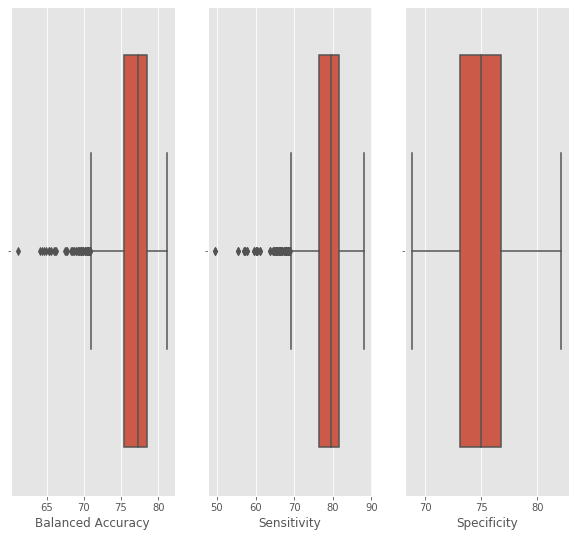

In [133]:
f, axes = plt.subplots(1,3, figsize = (10,9))
sns.boxplot(ax = axes[0], data = metrics_toplot, x = 'Balanced Accuracy')
sns.boxplot(ax = axes[1], data = metrics_toplot, x ='Sensitivity')
sns.boxplot(ax = axes[2], data = metrics_toplot, x = 'Specificity')

In [134]:
metrics_x_combns1 = metrics_toplot[metrics_toplot['EnsembleCombination'].str.contains('comb1')]

In [135]:
print(metrics_x_combns1['Balanced Accuracy'].mean())
print(metrics_x_combns1['Balanced Accuracy'].std())


75.96640671273455
2.3204832705979292


In [91]:
#metrics_x_combns1 = metrics_x_combns1.sort_values(by = ['Balanced Accuracy', 'EnsembleCombination'], ascending = [False, True])

In [136]:
metrics_x_combns1.describe()

,Prediction_CutOff,Total,Accuracy,Sensitivity,Specificity,Balanced Accuracy,Kappa,PPV,NPV
count,1013.000000,1013.0,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000
mean,0.544176,6677.0,73.909467,78.650257,73.282458,75.966407,0.334857,34.395005,94.811718
std,0.017938,0.0,1.688164,4.888999,1.841743,2.320483,0.057918,7.353014,2.478914
min,0.400000,6677.0,65.090000,49.530000,68.840000,61.190000,0.180000,15.760000,74.350000
25%,0.550000,6677.0,72.700000,76.230000,71.920000,74.920000,0.300000,29.130000,93.660000
50%,0.550000,6677.0,74.190000,79.270000,73.370000,76.400000,0.340000,34.850000,95.260000
75%,0.550000,6677.0,75.110000,82.020000,74.670000,77.590000,0.380000,39.910000,96.500000
max,0.550000,6677.0,77.890000,88.170000,79.250000,79.780000,0.470000,58.400000,98.490000


In [137]:
#metrics_x_combns1

In [138]:
top100_metrics_x_combns1 = metrics_x_combns1.head(100)

/home/grace/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/grace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


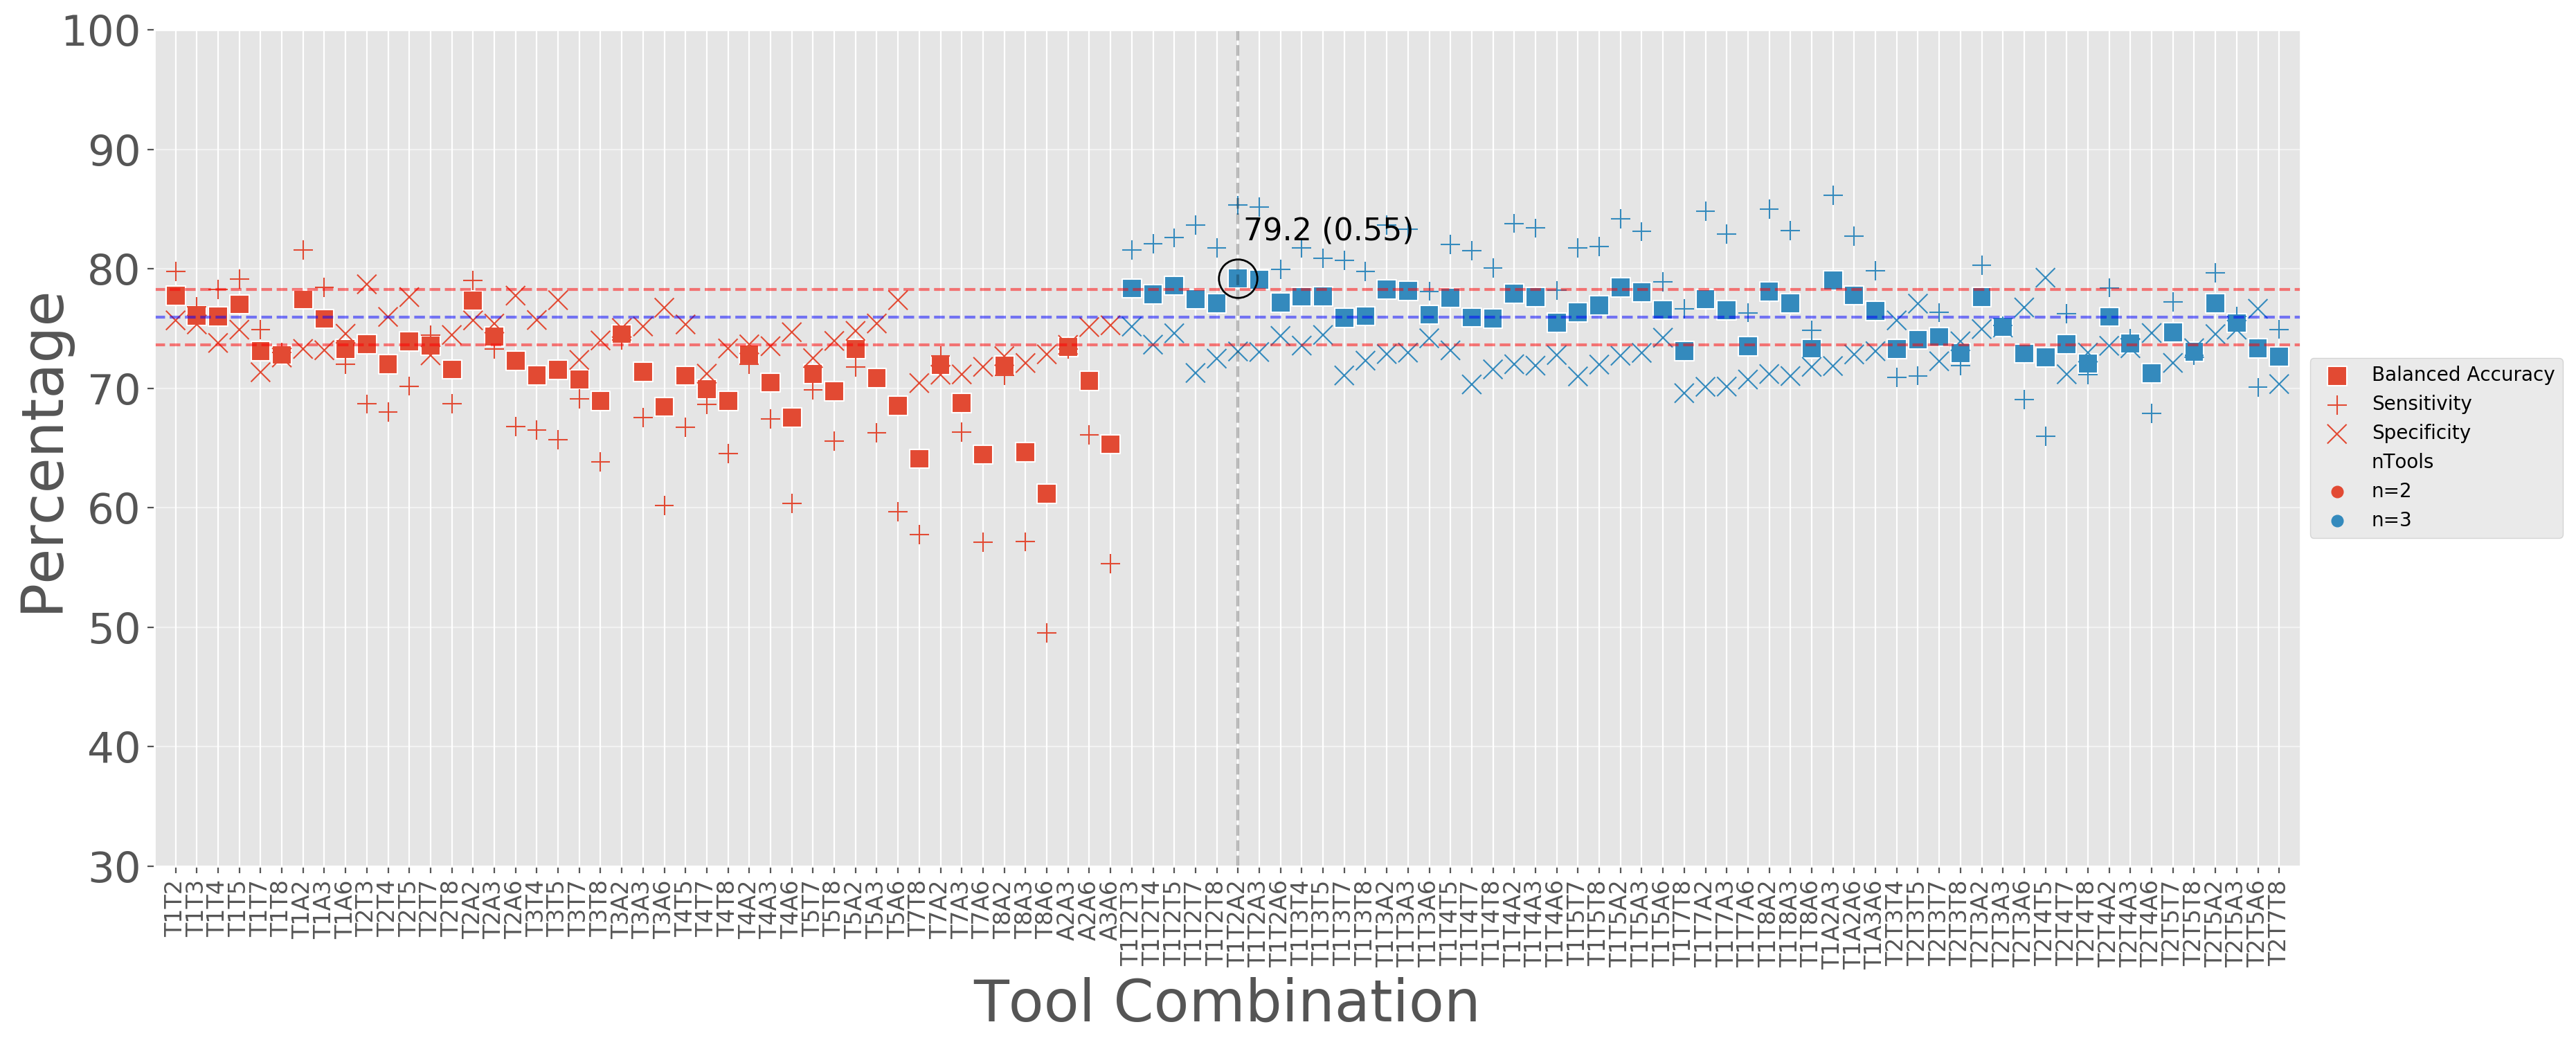

In [139]:

# Set the labels for x-axis - tool combinations
xaxis_label_dup = [combn.split('-')[1] for combn in combns]
xaxis_label = xaxis_label_dup[1::2]

# Combination 1
#metrics_x_combns1 = metrics_toplot[metrics_toplot['EnsembleCombination'].str.contains('comb1')]
plt.figure(figsize=(20, 8), dpi = 200)
top100_metrics_x_combns1.nTools=top100_metrics_x_combns1.nTools.astype('category')

ax = sns.scatterplot(x=range(len(top100_metrics_x_combns1)), y = 'Balanced Accuracy', hue='nTools', data=top100_metrics_x_combns1, marker = 's', s=100, label = 'Balanced Accuracy', legend = False)
ax = sns.scatterplot(x=range(len(top100_metrics_x_combns1)), y = 'Sensitivity', hue='nTools', data=top100_metrics_x_combns1, marker = '+', s=100, label = 'Sensitivity', legend = False)
ax = sns.scatterplot(x=range(len(top100_metrics_x_combns1)), y = 'Specificity', hue='nTools', data=top100_metrics_x_combns1, marker = 'x', s=100, label = 'Specificity')

top100_metrics_x_combns1['Balanced Accuracy'] = top100_metrics_x_combns1['Balanced Accuracy'].astype('float')
maxBA = top100_metrics_x_combns1.loc[top100_metrics_x_combns1['Balanced Accuracy'].idxmax()]['Balanced Accuracy']
pcutoff = top100_metrics_x_combns1.loc[top100_metrics_x_combns1['Balanced Accuracy'].idxmax()]['Prediction_CutOff']
maxAccPos = top100_metrics_x_combns1.index.get_loc(top100_metrics_x_combns1['Balanced Accuracy'].idxmax())
plt.plot(maxAccPos,maxBA,marker='o', markersize=20, color = 'k', fillstyle='none')
plt.axvline(maxAccPos, ls = '--', c = 'k', alpha = 0.25)
txt = '%0.1f (%0.2f)' %(maxBA, pcutoff)

plt.axhline(y = metrics_x_combns1['Balanced Accuracy'].mean(), ls = '--', c = 'b', alpha = 0.5)
plt.axhline(y = metrics_x_combns1['Balanced Accuracy'].mean()-metrics_x_combns1['Balanced Accuracy'].std() , ls = '--', c = 'r', alpha = 0.5)
plt.axhline(y = metrics_x_combns1['Balanced Accuracy'].mean()+metrics_x_combns1['Balanced Accuracy'].std() , ls = '--', c = 'r', alpha = 0.5)

plt.annotate(txt, [maxAccPos+0.25,maxBA+3.25], fontsize = 16)

plt.xticks(range(len(top100_metrics_x_combns1)),xaxis_label, fontsize = 12, rotation = 90)
plt.yticks(fontsize = 22)
plt.xlabel('Tool Combination', size = 30)
plt.ylabel('Percentage', size = 30, labelpad = -5)
#plt.legend(fontsize=14, loc='lower right')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylim([30,100])
plt.xlim([-1,len(top100_metrics_x_combns1)])
plt.grid(which='major', axis='y', alpha=0.5)
plt.savefig(figures_dir+'MetricsCombn1_170221.png', bbox_inches='tight')


In [140]:
metrics_x_combns2 = metrics_toplot[metrics_toplot['EnsembleCombination'].str.contains('comb2')]

In [141]:
metrics_x_combns2['Balanced Accuracy'].mean()

77.49273445212239

In [142]:
#metrics_x_combns2 = metrics_x_combns2.sort_values(by = ['Balanced Accuracy', 'EnsembleCombination'], ascending = [False, True])

In [143]:
metrics_x_combns2.describe()

,Prediction_CutOff,Total,Accuracy,Sensitivity,Specificity,Balanced Accuracy,Kappa,PPV,NPV
count,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000
mean,0.538746,5395.615005,76.739112,78.423554,76.561343,77.492734,0.419023,43.959704,93.565222
std,0.027704,740.742554,1.758485,4.713736,1.940295,2.360496,0.048898,6.457810,2.821467
min,0.350000,4426.000000,66.320000,49.530000,70.790000,64.950000,0.240000,23.940000,64.650000
25%,0.550000,4745.000000,76.110000,76.830000,75.570000,76.170000,0.400000,40.430000,93.280000
50%,0.550000,5059.000000,77.050000,79.860000,76.680000,78.160000,0.420000,44.010000,94.310000
75%,0.550000,6178.000000,77.850000,81.370000,77.650000,79.140000,0.450000,47.220000,95.090000
max,0.550000,6677.000000,80.320000,87.240000,82.120000,81.220000,0.520000,69.690000,97.350000


In [144]:
top100_metrics_x_combns2 = metrics_x_combns2.head(100)

/home/grace/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/grace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


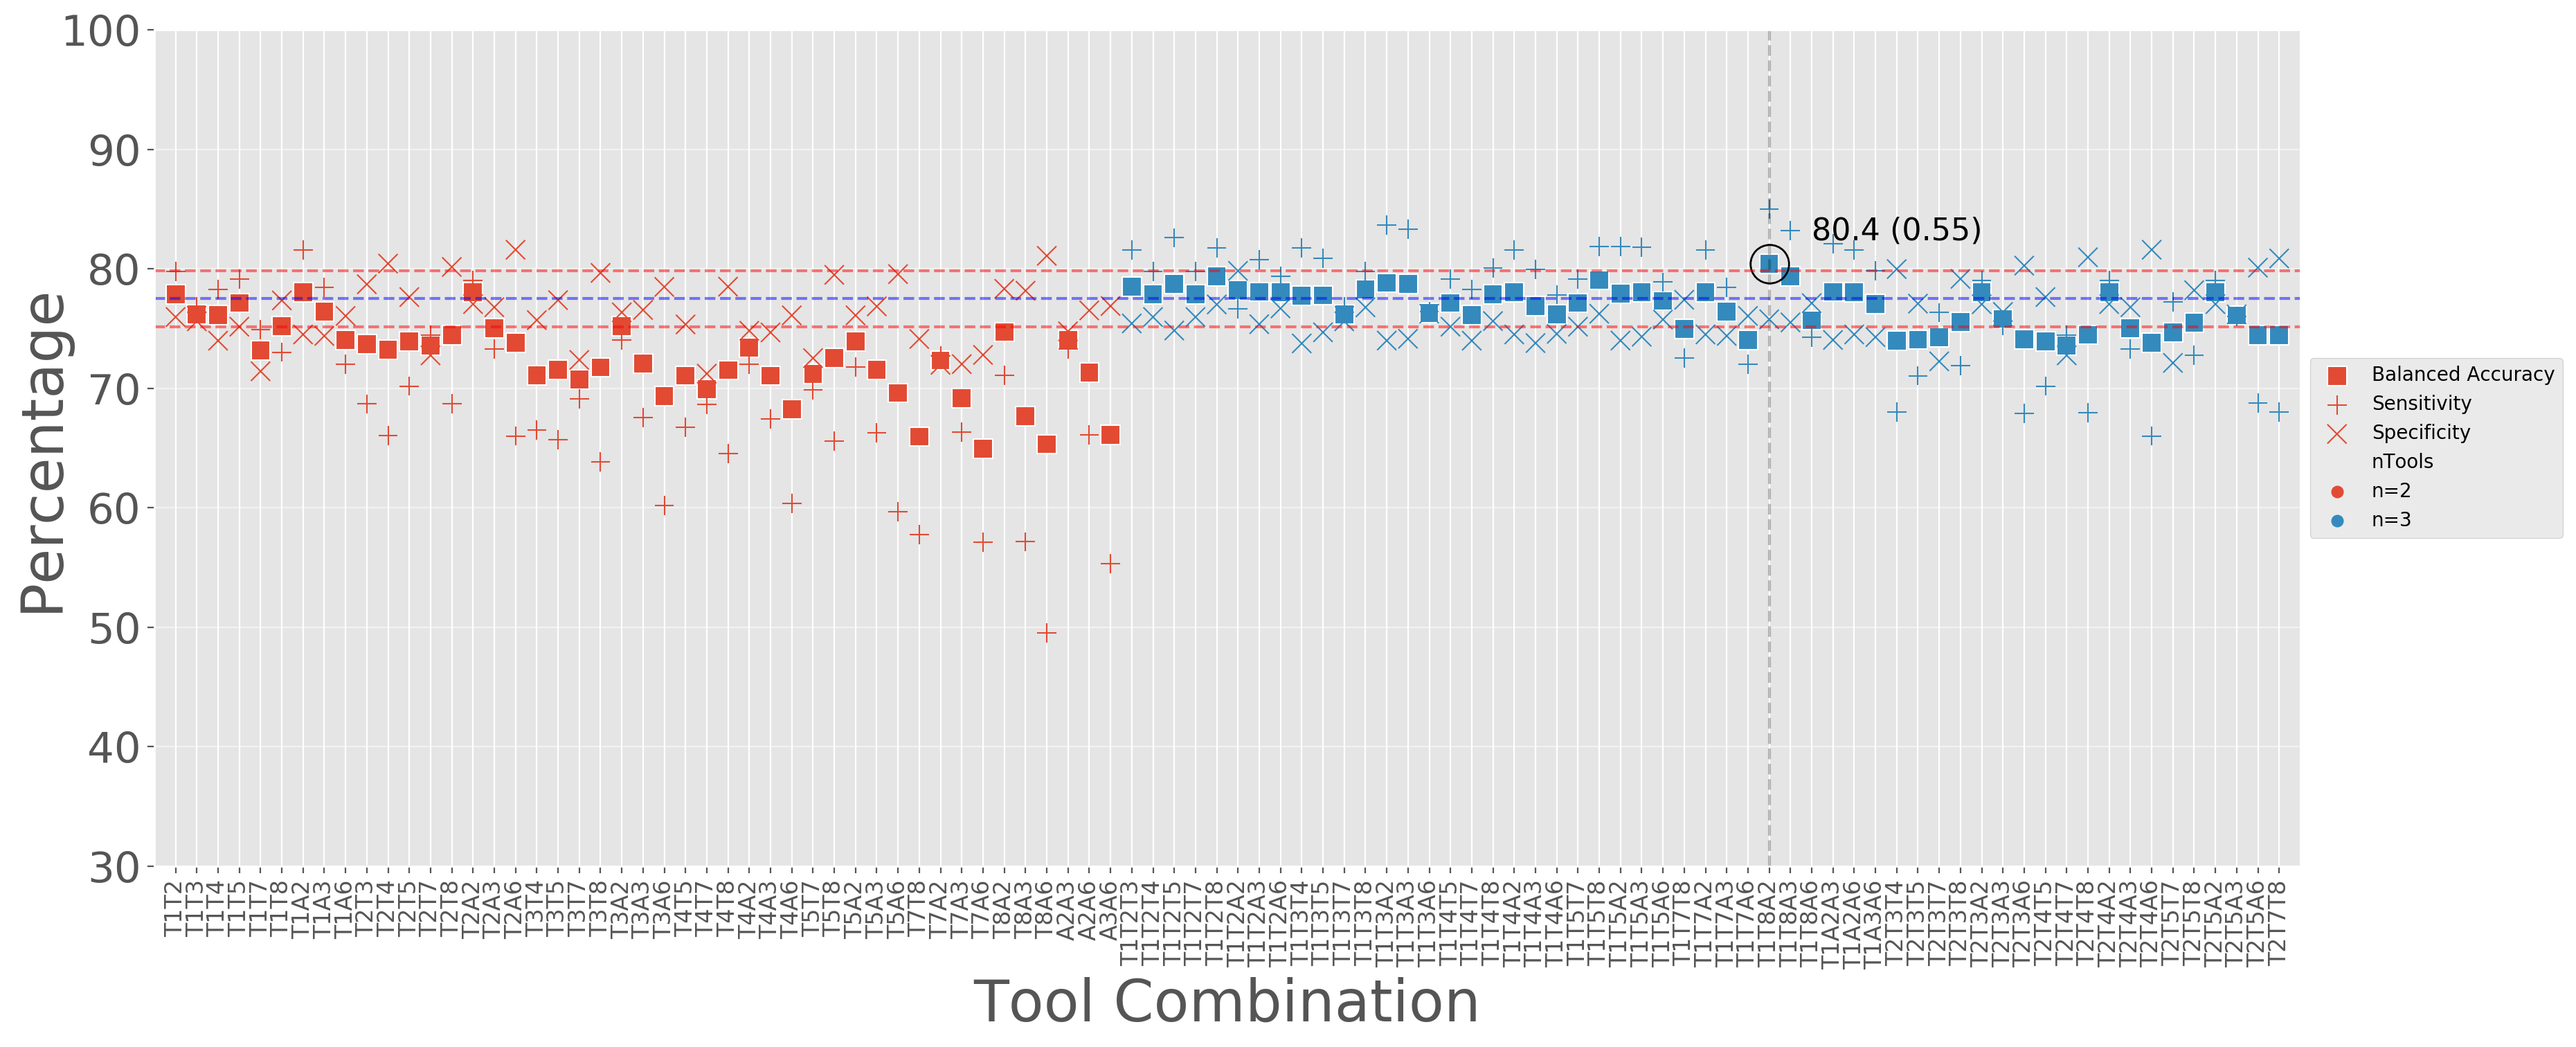

In [145]:
# Combination 2
#metrics_x_combns2 = metrics_toplot[metrics_toplot['EnsembleCombination'].str.contains('comb2')]
plt.figure(figsize=(20, 8), dpi = 200)
top100_metrics_x_combns2.nTools=top100_metrics_x_combns2.nTools.astype('category')

ax = sns.scatterplot(x=range(len(top100_metrics_x_combns2)), y = 'Balanced Accuracy', hue='nTools', data=top100_metrics_x_combns2, marker = 's', s=100, label = 'Balanced Accuracy', legend = False)
ax = sns.scatterplot(x=range(len(top100_metrics_x_combns2)), y = 'Sensitivity', hue='nTools', data=top100_metrics_x_combns2, marker = '+', s=100, label = 'Sensitivity', legend = False)
ax = sns.scatterplot(x=range(len(top100_metrics_x_combns2)), y = 'Specificity', hue='nTools', data=top100_metrics_x_combns2, marker = 'x', s=100, label = 'Specificity')

top100_metrics_x_combns2['Balanced Accuracy'] = top100_metrics_x_combns2['Balanced Accuracy'].astype('float')
maxBA = top100_metrics_x_combns2.loc[top100_metrics_x_combns2['Balanced Accuracy'].idxmax()]['Balanced Accuracy']
pcutoff = top100_metrics_x_combns2.loc[top100_metrics_x_combns2['Balanced Accuracy'].idxmax()]['Prediction_CutOff']
maxAccPos = top100_metrics_x_combns2.index.get_loc(top100_metrics_x_combns2['Balanced Accuracy'].idxmax())
plt.plot(maxAccPos,maxBA,marker='o', markersize=20, color = 'k', fillstyle='none')
plt.axvline(maxAccPos, ls = '--', c = 'k', alpha = 0.25)

plt.axhline(y = metrics_x_combns2['Balanced Accuracy'].mean(), ls = '--', c = 'b', alpha = 0.5)
plt.axhline(y = metrics_x_combns2['Balanced Accuracy'].mean()-metrics_x_combns2['Balanced Accuracy'].std() , ls = '--', c = 'r', alpha = 0.5)
plt.axhline(y = metrics_x_combns2['Balanced Accuracy'].mean()+metrics_x_combns2['Balanced Accuracy'].std() , ls = '--', c = 'r', alpha = 0.5)



txt = '%0.1f (%0.2f)' %(maxBA, pcutoff)
plt.annotate(txt, [maxAccPos+2,maxBA+2], fontsize = 16)

plt.xticks(range(len(top100_metrics_x_combns2)),xaxis_label, fontsize = 12, rotation = 90)
plt.yticks(fontsize = 22)
plt.xlabel('Tool Combination', size = 30)
plt.ylabel('Percentage', size = 30, labelpad = -5)
#plt.legend(fontsize=14, loc='lower right')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([30,100])
plt.xlim([-1,len(top100_metrics_x_combns2)])
plt.grid(which='major', axis='y', alpha=0.5)
plt.savefig(figures_dir+'MetricsCombn2_170221.png', bbox_inches='tight')

In [150]:
metrics_x_combns2.sort_values(by = ['Balanced Accuracy', 'Sensitivity'], ascending = [False, False])

,EnsembleCombination,Truth,Prediction_CutOff,nTools,Total,Accuracy,Sensitivity,Specificity,Balanced Accuracy,Kappa,PPV,NPV
comb2_4-T1T5T8A3_PredCutOff0.55|DeMarini,comb2_4-T1T5T8A3,Williamns et al. 2019 Calls,0.55,n=4,4542.0,76.86,87.24,75.20,81.22,0.39,36.03,97.35
comb2_6-T1T2T7T8A3A6_PredCutOff0.55|DeMarini,comb2_6-T1T2T7T8A3A6,Williamns et al. 2019 Calls,0.55,n=6,4542.0,77.96,85.85,76.47,81.16,0.43,40.78,96.63
comb2_5-T1T2T8A3A6_PredCutOff0.55|DeMarini,comb2_5-T1T2T8A3A6,Williamns et al. 2019 Calls,0.55,n=5,4542.0,77.63,86.17,76.09,81.13,0.42,39.39,96.83
comb2_5-T1T5T8A3A6_PredCutOff0.55|DeMarini,comb2_5-T1T5T8A3A6,Williamns et al. 2019 Calls,0.55,n=5,4542.0,76.95,86.74,75.34,81.04,0.39,36.63,97.19
comb2_5-T1T3T5T8A3_PredCutOff0.55|DeMarini,comb2_5-T1T3T5T8A3,Williamns et al. 2019 Calls,0.55,n=5,4542.0,76.66,86.94,75.04,80.99,0.38,35.51,97.32
...,...,...,...,...,...,...,...,...,...,...,...,...
comb2_2-T8A3_PredCutOff0.45|DeMarini,comb2_2-T8A3,Williamns et al. 2019 Calls,0.45,n=2,4745.0,71.38,57.15,78.16,67.66,0.35,55.49,79.29
comb2_2-A3A6_PredCutOff0.45|DeMarini,comb2_2-A3A6,Williamns et al. 2019 Calls,0.45,n=2,6179.0,69.38,55.34,76.88,66.11,0.32,56.13,76.31
comb2_2-T7T8_PredCutOff0.45|DeMarini,comb2_2-T7T8,Williamns et al. 2019 Calls,0.45,n=2,5059.0,70.27,57.77,74.12,65.95,0.28,40.73,85.07
comb2_2-T8A6_PredCutOff0.40|DeMarini,comb2_2-T8A6,Williamns et al. 2019 Calls,0.40,n=2,4745.0,66.32,49.53,81.08,65.31,0.31,69.69,64.65


Comparing the highest performing combination relative to the individual models - comb2-4T1T5T8A3 scores better than everything except specificity.

In [151]:
metrics_tools = pd.read_csv(processed_dat_dir+'metrics_tools_120221.csv')

In [153]:
metrics_tools.Specificity.mean()

77.99

In [154]:
metrics_tools.Sensitivity.mean()

54.784666666666666

Final model generation

In [197]:
final_comb = 'comb2_4-T1T5T8A3'
final_comb_post_prob = {}

for comb in x_combns[final_comb].dropna().unique():
    print(comb)
    try:
        n_comb = len(x_combns[x_combns[final_comb]==comb])
        
        n_1_comb = len(x_combns[(x_combns[final_comb]==comb) & (x_combns['demarini']==1)])
        
        final_comb_post_prob[comb] = round(n_1_comb/n_comb,2)
    except:
        final_comb_post_prob[comb] = np.nan


15.0
4.0
12.0
14.0
7.0
11.0
8.0
0.0
6.0
5.0
2.0
9.0
10.0
13.0
1.0
3.0


In [157]:
x_combns[final_comb].dropna().unique()

array([15.,  4., 12., 14.,  7., 11.,  8.,  0.,  6.,  5.,  2.,  9., 10.,
       13.,  1.,  3.])

63

In [164]:
x_combns[[final_comb, 'demarini']].dropna()

,comb2_4-T1T5T8A3,demarini
DTXSID00157169,15.0,1.0
DTXSID00160734,4.0,0.0
DTXSID00163705,12.0,0.0
DTXSID00167147,15.0,1.0
DTXSID00167506,7.0,1.0
...,...,...
DTXSID90890477,2.0,0.0
DTXSID90890619,3.0,0.0
DTXSID90890811,0.0,0.0
DTXSID90891080,2.0,0.0


In [168]:
final_model = pd.DataFrame(list(final_comb_post_prob.items()), columns = ['index','Probability'])


In [174]:
final_model = final_model.sort_values('index', ascending = True)

In [176]:
final_model.columns = ['Combination_Number', 'Posterior_Probability']

In [184]:
final_model['Prediction_Outcome'] = final_model['Posterior_Probability'].apply(lambda x: 'genotoxic' if x>= 0.55 else 'non-genotoxic')

In [188]:
final_model

,Combination_Number,Posterior_Probability,Prediction_Outcome
7,0.0,0.14,non-genotoxic
14,1.0,0.18,non-genotoxic
10,2.0,0.22,non-genotoxic
15,3.0,0.40,non-genotoxic
1,4.0,0.19,non-genotoxic
9,5.0,0.38,non-genotoxic
8,6.0,0.29,non-genotoxic
4,7.0,0.51,non-genotoxic
6,8.0,0.09,non-genotoxic
11,9.0,0.20,non-genotoxic


In [186]:
final_model
final_model.to_csv(processed_dat_dir+'FinalModel_180221.csv')

Sanity check with previous analysis

In [178]:
df =pd.read_csv(processed_dat_dir+'metrics_combns.csv')

In [181]:
df[df['EnsembleCombination'] =='comb2_5-T1T2A1A3A4']

,Combination,EnsembleCombination,Truth,Prediction_CutOff,nTools,Total,Accuracy,Sensitivity,Specificity,Balanced Accuracy,Kappa
909,comb2_5-T1T2A1A3A4_PredCutOff0.15|DeMarini,comb2_5-T1T2A1A3A4,Williamns et al. 2019 Calls,0.15,n=5,1800.0,56.17,87.47,32.12,59.80,0.18
910,comb2_5-T1T2A1A3A4_PredCutOff0.20|DeMarini,comb2_5-T1T2A1A3A4,Williamns et al. 2019 Calls,0.20,n=5,1800.0,73.78,73.66,73.87,73.77,0.47
911,comb2_5-T1T2A1A3A4_PredCutOff0.25|DeMarini,comb2_5-T1T2A1A3A4,Williamns et al. 2019 Calls,0.25,n=5,1800.0,77.39,68.67,84.09,76.38,0.53
912,comb2_5-T1T2A1A3A4_PredCutOff0.30|DeMarini,comb2_5-T1T2A1A3A4,Williamns et al. 2019 Calls,0.30,n=5,1800.0,77.50,67.52,85.17,76.34,0.54
913,comb2_5-T1T2A1A3A4_PredCutOff0.35|DeMarini,comb2_5-T1T2A1A3A4,Williamns et al. 2019 Calls,0.35,n=5,1800.0,76.89,59.46,90.28,74.87,0.51
914,comb2_5-T1T2A1A3A4_PredCutOff0.40|DeMarini,comb2_5-T1T2A1A3A4,Williamns et al. 2019 Calls,0.40,n=5,1800.0,76.28,53.71,93.61,73.66,0.50
915,comb2_5-T1T2A1A3A4_PredCutOff0.45|DeMarini,comb2_5-T1T2A1A3A4,Williamns et al. 2019 Calls,0.45,n=5,1800.0,73.44,45.91,94.60,70.25,0.43
916,comb2_5-T1T2A1A3A4_PredCutOff0.50|DeMarini,comb2_5-T1T2A1A3A4,Williamns et al. 2019 Calls,0.50,n=5,1800.0,67.94,28.77,98.04,63.41,0.29
917,comb2_5-T1T2A1A3A4_PredCutOff0.55|DeMarini,comb2_5-T1T2A1A3A4,Williamns et al. 2019 Calls,0.55,n=5,1800.0,61.83,13.30,99.12,56.21,0.14
